In [1]:
import sys
import os
import xml.etree.ElementTree
import csv
import re
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

# Openstreetmap Project

The goal of this project is to parse data from a openstreetmap OSM file (XML format), populate a database and perform some analysis.

## List of modules used

In [2]:
print("Python: Version {}".format(sys.version))
print("xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.")
print("csv: Version {}".format(csv.__version__))
print("re: Version {}".format(re.__version__))
#print("sqlite3: Version {}".format(sqlite3.__version__))
print("pandas: Version {}".format(pd.__version__))
print('matplotlib: Version {}'.format(matplotlib.__version__))
print('numpy: Version {}'.format(np.__version__))

Python: Version 3.6.0 |Anaconda 4.3.1 (32-bit)| (default, Dec 23 2016, 12:06:52) [MSC v.1900 32 bit (Intel)]
xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.
csv: Version 1.0
re: Version 2.2.1
pandas: Version 0.19.2
matplotlib: Version 2.0.0
numpy: Version 1.11.3


## Set the data file

In [3]:
#dataFileName = 'example.osm'
#dataFileName = 'daensen.osm'
dataFileName = 'pippensen.osm'
#dataFileName = 'tulle.osm'
#dataFileName = 'Hamburg_sued.osm'
#dataFileName = 'Buxtehude.osm'
#dataFileName = 'Paris.osm'

In [4]:
statinfo = os.stat(dataFileName)
print('Size of the source file {}: {:.3f}Mb'.format(dataFileName, statinfo.st_size / (1024 * 1024))) 

Size of the source file pippensen.osm: 6.207Mb


Database filename

In [5]:
dbFileName = 'Openstreetmap.db'

# Read data from OSM file and create some csv files

The first part is to read the data from the OSM file and export them to some CSV files.

For clarity the process is split in several functions (see below). Then main function is called 'parseOSMfile'.

The OSM file is opened with the XML parser and the elements are read in sequence. The data are store in the relevant CSV file.

At the end, one CSV file will be obtain per table in the database.

In [21]:
# List of all csv files
csvFiles = {'node':'nodes.csv',
         'way':'ways.csv',
         'node_tags': 'nodes_tags.csv',
         'way_tags': 'ways_tags.csv',
         'way_node':'ways_nodes.csv'}

# List of all fields for the csv files and the database
fields = {'node': ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'way': ['id', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'node_tags': ['id', 'key', 'value', 'type'],
           'way_tags': ['id', 'key', 'value', 'type'],
           'way_node': ['id', 'node_id', 'position']} 

def initCSVfiles():
    '''
    Create empty csv files and add the header line
    
    parameters:
    ------------
    None
    
    returns:
    --------
    a dictionary containing the file descriptor and the csv writer object
    '''
    fileDescriptor = {}
    for f in csvFiles:
        #print('init {}'.format(files[f]))
        fileId = open(csvFiles[f], 'w', encoding='utf-8')
        csvWriter = csv.writer(fileId, delimiter=';',
                            quotechar='\'', quoting=csv.QUOTE_MINIMAL)
        csvWriter.writerow(fields[f])
        fileDescriptor[f] = {}
        fileDescriptor[f]['fileId'] = fileId
        fileDescriptor[f]['csvWriter'] = csvWriter
        
    return fileDescriptor

def closeCSVfiles(fileDesc):
    '''
    Close all csv files opened
    
    parameters:
    -----------
    the file descriptor dictionary returned by the initCSVfiles function.
    
    returns:
    --------
    None
    '''
    for f in fileDesc:
        fileDesc[f]['fileId'].close()

def writeElem(elemType, elem, fileDesc):
    '''
    write an element in the corresponding csv file
    
    parameters:
    -----------
    - elemType: a string of the type of element to be written.
    - elem: dict of data to be written in the csv file
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)
    
    returns:
    --------
    None
    '''
    record = []
    for i in fields[elemType]:
        record.append(elem[i])
    
    fileDesc[elemType]['csvWriter'].writerow(record)

def correctBadCaracters(string):
    '''
    remove problematic charracteres from a stings.
    
    All special character in the form '&#xxx;' will be removed and semi-colon will be replaced by a space char.
    
    parameters:
    -----------
    - string: the string to be corrected
    
    returns:
    --------
    the input string without problematic characters
    '''
    correctedString = ''
    start = 0
    end = 0
    
    # Remove the '&#xxx' special caracters
    pattern = r'&#?.*?;'
    if re.search(pattern, string):
        for m in re.finditer(pattern, string):
            end = m.start()
            correctedString += string[start:end]
            start = m.end()
    else:
        correctedString = string
    
    # Remove remaning semi-colon
    correctedString = correctedString.replace(';', ' ')
    
    return correctedString
    
def parseTag(id, attrib):
    '''
    Parse the tag k and return the value, the key and the type
    
    parameters:
    -----------
    - id: id of the node or the way
    - attrib: XML object
    
    returns:
    --------
    a dictionary with the Id of the parent, the key, value and type
    '''
    
    if 'k' in attrib:
        pattern = re.compile('^([a-z_]+):(.*)$')
        match = pattern.match(attrib['k'])
    
        if match:
            type_ = match.group(1)
            key = match.group(2)
        else:
            type_ = attrib['k']
            key = ''
    else:
        key = None
        type_ = None
    
    # Correct the value string which can contain problematic characters
    value = correctBadCaracters(attrib['v'])
    return {'id': id, 'key':key, 'value':value, 'type':type_}
    
def parseElement(element, fileDesc):
    '''
    parse an element and write the data in the different csv files
    
    parameters:
    -----------
    - element: XML object to be parsed
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)

    returns:
    --------
    None
    '''
    targetElement = ['node', 'way']
    
    if element.tag in targetElement:
        #print('Parsing: {}'.format(element.tag))
        selectedAttribs = fields[element.tag]

        # Parse the main elements Node and Way
        attribs = element.attrib
        elem = {}
        for i in selectedAttribs:
            elem[i] = attribs[i]  
        writeElem(element.tag, elem, fileDesc)
        
        # Parse the subelements Tag and Nd
        position = 0
        for e in element:
            tag = {}
            node = {}
            if e.tag == 'nd':
                node = {'id': elem['id'], 'node_id': e.attrib['ref'], 'position': position}
                position += 1
                writeElem('way_node', node, fileDesc)
            elif e.tag == 'tag':
                tag = parseTag(elem['id'], e.attrib)
                writeElem(element.tag + '_tags', tag, fileDesc)
        
def parseOSMfile(fileName):
    '''
    main function to extract the data from an OSM file to CSV files
    
    parameters:
    -----------
    fileName: string of the path of the OSM file
    
    returns:
    --------
    None
    '''
    fileDesc = initCSVfiles()
    e = xml.etree.ElementTree.parse(fileName).getroot()
    for element in e:
        parseElement(element, fileDesc)
    closeCSVfiles(fileDesc)

The CSV files can be generated:

In [22]:
parseOSMfile(dataFileName)

List of all CSV files in the current directory:

In [8]:
fileList = os.listdir()

print('List of csv files.')
pattern = re.compile('.*\.csv$')
for f in fileList:
    if pattern.match(f):
        statinfo = os.stat(f)
        print('File {} ({:.1f}kb)'.format(f, statinfo.st_size / 1024))
    

List of csv files.
File nodes.csv (1998.0kb)
File nodes_tags.csv (104.8kb)
File node_tags.csv (3.9kb)
File ways.csv (249.0kb)
File ways_nodes.csv (758.3kb)
File ways_tags.csv (315.0kb)
File way_node.csv (19.5kb)
File way_tags.csv (8.2kb)


Those files can be used to populate the database

# Create the database

From the CSV, it is now easy to populate the database. The first step will be to create one with the adequat tables. The database will be created with the schema contains in the file 'data_wrangling_schema.sql'

The database is a SQLite one.

In [9]:
# To avoid errors, if the database file does not exist, it is created else just the connexion will be established.
if not os.path.isfile(dbFileName):
    conn = sqlite3.connect(dbFileName)
    c = conn.cursor()
    with open('data_wrangling_schema.sql') as f:
        print('Creating database...')
        text = f.read()
        c.executescript(text)
        conn.commit()
        print('Execute SQL statement: \n{}'.format(text))
else:
    print('Database file {} already exists. This file will be use.'.format(dbFileName))
    conn = sqlite3.connect(dbFileName)
    c = conn.cursor()

Database file Openstreetmap.db already exists. This file will be use.


# Populate the database

The database file exists, it can be populated with the CSV files previously generated.

In [10]:
def populateDatabase(dbConn):
    '''
    populate the database with the CSV files.
    
    The name of the files and the table are extracted from the global table 'csvFiles'
    
    parameters:
    -----------
    - dbConn: connexion variable to the database
    
    returns:
    --------
    None
    '''
    for f in csvFiles:
        print('Reading file {} for table {}'.format(csvFiles[f], csvFiles[f].split('.')[0]))
        df = pd.read_csv(csvFiles[f], sep=';', dtype={"id": np.int32})
        df.to_sql(csvFiles[f].split('.')[0], dbConn, if_exists='replace', index=False)

In [11]:
populateDatabase(conn)

Reading file nodes.csv for table nodes
Reading file ways.csv for table ways
Reading file nodes_tags.csv for table nodes_tags
Reading file ways_tags.csv for table ways_tags
Reading file ways_nodes.csv for table ways_nodes


Now the database is populated and can be used.

# Analysis of the data

## How many nodes in the database?

In [12]:
c.execute('SELECT COUNT(id) FROM nodes')
print('There are {} nodes in the database'.format(c.fetchall()[0][0]))

There are 24556 nodes in the database


## How many ways in the database?

In [13]:
c.execute('SELECT COUNT(id) FROM ways')
print('There are {} ways in the database'.format(c.fetchall()[0][0]))

There are 4146 ways in the database


## How many users are in the tables?

In [14]:
c.execute('SELECT COUNT(DISTINCT user) FROM ways')
print('There are {} different users in the ways table'.format(c.fetchall()[0][0]))

c.execute('SELECT COUNT(DISTINCT user) FROM nodes')
print('There are {} different users in the nodes table'.format(c.fetchall()[0][0]))

There are 99 different users in the ways table
There are 121 different users in the nodes table


## List of different type of elements in the file

It is possible to have an idea of what sort of information are contains by having a look to the field 'type' of the nodes tags.

In [15]:
sqlQuery = 'SELECT DISTINCT nodes_tags.type \
          FROM nodes_tags;'
df = pd.read_sql(sqlQuery, conn)
print(df.values)

[['bus']
 ['name']
 ['public_transport']
 ['note']
 ['source']
 ['traffic_sign']
 ['highway']
 ['is_in']
 ['place']
 ['wikidata']
 ['created_by']
 ['wikipedia']
 ['power']
 ['ref']
 ['crossing']
 ['alt_name']
 ['railway']
 ['hazard']
 ['button_operated']
 ['waterway']
 ['route_ref']
 ['shelter']
 ['opening_hours']
 ['shop']
 ['wheelchair']
 ['barrier']
 ['leisure']
 ['sport']
 ['crossing_ref']
 ['amenity']
 ['religion']
 ['bicycle']
 ['foot']
 ['tourism']
 ['check_date']
 ['collection_times']
 ['operator']
 ['addr']
 ['fuel']
 ['phone']
 ['maxspeed']
 ['recycling']
 ['recycling_type']
 ['man_made']
 ['start_date']
 ['website']
 ['fence_type']
 ['contact']
 ['parking']
 ['access']
 ['playground']
 ['emergency']
 ['fire_hydrant']
 ['bench']
 ['waste_basket']
 ['bin']
 ['entrance']
 ['noexit']
 ['water_tank']
 ['waste']
 ['building']
 ['bicycle_parking']
 ['generator']
 ['traffic_signals']
 ['historic']
 ['inscription']
 ['memorial']
 ['material']
 ['smoking']
 ['toilets']
 ['local_ref']


## What about fire protection?

The type 'water_hydrant' can be interessing to see.

In [16]:
c.execute('SELECT count(type) \
          FROM nodes_tags \
          WHERE type == \'fire_hydrant\' AND nodes_tags.key = \'type\';')
print('There are {} fire hydrant in the database'.format(c.fetchall()[0][0]))

There are 139 fire hydrant in the database


It should be possible to see their location. We can extract their position in latitude and longitude from the nodes table.

Displaying only the position it is hard to really see. We will extract also the ways and the name of the places.

*Note: For performance reason, the map can take some times to be generated. It is possible to deactivate the generation of the ways by setting the parameter 'plotWays' to False. The parameter 'plotPlace' can also be set to False but it not improve the performance just the visualization.*

In [17]:
def plotMap(plotWays = True, plotPlaces = True):
    # Extraction of the ways.
    if plotWays:
        sqlQuery = 'SELECT ways_nodes.id, ways_nodes.position, nodes.lat, nodes.lon \
              FROM ways_nodes \
              JOIN nodes \
              WHERE ways_nodes.node_id = nodes.id;'
        df = pd.read_sql(sqlQuery, conn)
        wayList = df['id'].unique()
        for way in wayList:
            singleWay = df[df['id'] == way].sort_values(by = ['position'])
            plt.plot(singleWay['lon'], singleWay['lat'], c='k', alpha=0.3)
    
    # Extraction of the name of the place.
    # For that a self join is needed because the name of the place separate from the type.
    # Also in name are given in German and Plattdeutsch. Only the German name should be selected
    # (it is the reason of the 'B.key IS NULL')
    if plotPlaces:
        sqlQuery = 'SELECT B.value, nodes.lat, nodes.lon \
              FROM nodes_tags A, nodes_tags B \
              JOIN nodes \
              ON nodes.id = A.id \
              WHERE A.type = \'place\' \
              AND B.type = \'name\' AND B.key IS NULL\
              AND A.id = B.id;'
        df = pd.read_sql(sqlQuery, conn)
        for i in range(df.shape[0]):
            plt.annotate(df.iloc[i]['value'], xy=(df.iloc[i]['lon'], df.iloc[i]['lat']), fontsize=15)

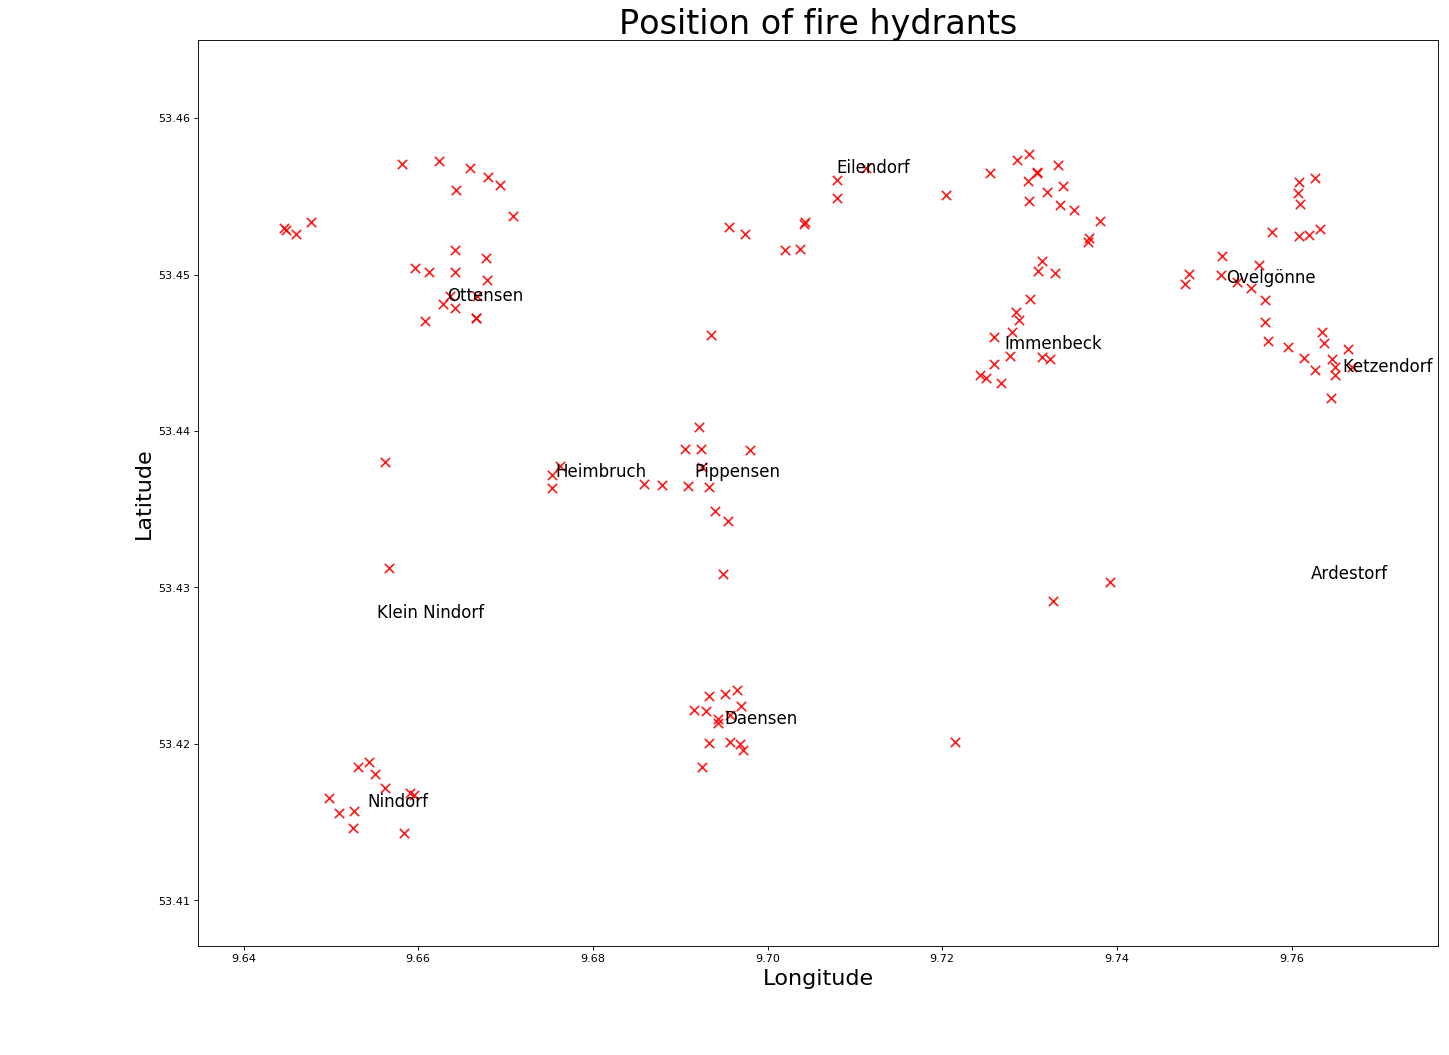

In [18]:
# Extract all Fire_hydrant with their latitude and longitude
sqlQuery = 'SELECT nodes.lat, nodes.lon, nodes_tags.type, nodes_tags.key, nodes_tags.value \
          FROM nodes \
          JOIN nodes_tags ON nodes.id = nodes_tags.id \
          WHERE nodes_tags.type == \'fire_hydrant\' AND nodes_tags.key = \'type\';'
df = pd.read_sql(sqlQuery, conn)


plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')  
plotMap(plotWays = False)
plt.title('Position of fire hydrants', fontdict={'fontsize': 30})
plt.xlabel('Longitude', fontdict={'fontsize': 20})
plt.ylabel('Latitude', fontdict={'fontsize': 20})
plt.scatter(df['lon'], df['lat'], marker='x', s=70, c='r', alpha=0.9)
plt.show()

## Check of the name of the objects

A quality check of the naming has to be done.

In [19]:
sqlQuery = 'SELECT DISTINCT value FROM ways_tags WHERE type == \'addr\' AND key=\'street\''
names = pd.read_sql(sqlQuery, conn)
names

,value
0,Zum Lehmfeld
1,Am Dorfteich
2,Zum Schlüsselberg
3,Ovelgönner Straße
4,Am Jehrdenberg
5,Grauener Weg
6,Fliegenmoor
7,Ardestorfer Weg
8,Inne Beek
9,Schaffeld


In Germany the  naming convention of the street is quite tricky. Some street have only one word for some others Straße or Weg are separated and some other contains some hyphens. The rule is as the following:
- The standard id to name the ways or place with one word. (Like 'Torfweg' or 'Falkenstraße')
- If the name refers to a person and this name is only one word, the name will be written in one word (e.g. Goethestraße)
- If the name refers to a person and this name is composed by several words, the name will be written in several words but separate by an hypen (e.g. 'Catharina-Gerkens-Weg')
- If the name refer to a place, it will be written in several words (e.g. 'Buxtehuder Straße')
- If the name refer to a quality (straight, blue...), it will be written in several words (e.g. 'Blauer Weg', 'Alter Platz')

In Germany, the name of the street are often written as "str" instead of 'Straße' (e.g. 'Landstr.')

To verify all this rules a dictionary will be needed. This is out of scope of this project but can be taken for improvements.

What can be done is:
- Check the extention of the street name ('Straße' and not 'Str.') (Can be done automaticaly)
- Correctness of the hyphenation (should be done manually)
- Check of name if refers to a place (it will end by 'er'). (should be done partily manually)

### Check of the extentions

The name of the streets must be ' Straße' or '\*straße' and not ' Str. or '\*str.'

In [45]:
names[names.value.str.match('.* ?[sS]tr\.?$')]

,value


No result. It seems that all Straße are corectly spelled.

### Check the correctness of the hyphenation

The check is to see if some name are composed by only two words or not composed by a name of a person.

In [47]:
names[names.value.str.match('\w+\-')]

,value
38,Fritz-Ehlers-Weg
41,Claus-Dammann-Weg
54,Carl-Zeiss-Straße
84,Catharina-Gerkens-Weg


All are named from People and are composed by several words. It is all correct.

### Check the correctness of the name composed by a place

The name of the place are in general ended by 'er'. The name should be like 'Buxtehuder Straße'. All name composed by *erstraße, *erweg or *erplatz are suspect and should be verified.

In [50]:
names[names.value.str.match('.*er .*$')]

,value
3,Ovelgönner Straße
5,Grauener Weg
7,Ardestorfer Weg
12,Apensener Straße
13,Beim Kloster Dohren
19,Lüdenstorfer Feld
20,Delmer Bogen
39,Nindorfer Straße
45,Heimbrucher Straße
51,Moisburger Landstraße


In [70]:
names[names.value.str.match('.*er(?:str|weg|platz).*$')]

,value
73,Kasperstraße


## Correction of values in the database

As we see the quality of the data are quite good. There is nothing to really correct.

As example we will merge the name contains Straße. It is wring but this can be usefull in the futur, if a better error detection algorythm is available.

First we can extract the name of the street we want to change (this can be given by an algorithm which check the error with a dictionary)

In [135]:
originalNames = names[names.value.str.match('.*er Straße$')]
originalNames

,value
3,Ovelgönner Straße
12,Apensener Straße
39,Nindorfer Straße
45,Heimbrucher Straße
56,Harburger Straße
72,Buxtehuder Straße


Change a the values

In [136]:
def glueName(name):
    name = name.split(' ')
    return ''.join(name[0:-1]) + 'straße'



In [139]:
newNames = originalNames['value'].apply(glueName).values.flatten()

In [140]:
newNames

array(['Ovelgönnerstraße', 'Apensenerstraße', 'Nindorferstraße',
       'Heimbrucherstraße', 'Harburgerstraße', 'Buxtehuderstraße'], dtype=object)

In [143]:
sqlUpdateRequest = 'UPDATE ways_tags SET value = \'{}\' WHERE value = \'{}\''
for i in range(len(originalNames['value'].values.flatten())):
    print(sqlUpdateRequest.format(newNames[i], originalNames['value'].values.flatten()[i]))

UPDATE ways_tags SET value = 'Ovelgönnerstraße' WHERE value = 'Ovelgönner Straße'
UPDATE ways_tags SET value = 'Apensenerstraße' WHERE value = 'Apensener Straße'
UPDATE ways_tags SET value = 'Nindorferstraße' WHERE value = 'Nindorfer Straße'
UPDATE ways_tags SET value = 'Heimbrucherstraße' WHERE value = 'Heimbrucher Straße'
UPDATE ways_tags SET value = 'Harburgerstraße' WHERE value = 'Harburger Straße'
UPDATE ways_tags SET value = 'Buxtehuderstraße' WHERE value = 'Buxtehuder Straße'


# Close the database

Now the database connection can be closed.

In [20]:
conn.close()

# Possible improvment

- Check the name of the place with a dicionnary.
- Add better data visulatzation to see the repatition of the objects